In [1]:
import numpy as np
from keras import applications, callbacks
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras import optimizers
from keras.applications import vgg16

import keras.backend as K

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls

drive  sample_data


In [5]:
datasetPath = 'drive/MyDrive/Capstone Project/dataset_binaries/'
savedModelPath = 'drive/MyDrive/Capstone Project/saved_models_binaries/'

In [6]:
x_train=np.load(datasetPath + 'x_train_np.npy')
x_cv=np.load(datasetPath + 'x_cv_np.npy')
y_train=np.load(datasetPath + 'y_train_np.npy')
y_cv=np.load(datasetPath + 'y_cv_np.npy')


Fine Tune Model

In [7]:
# load VGG16
vgg_model=vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))

58900480/58889256 [==============================] - 1s 0us/step


In [8]:
model_aug=Sequential()
model_aug.add(vgg_model)

In [9]:
top_model=Sequential()
top_model.add(Flatten(input_shape=(2, 2, 512)))
top_model.add(Dense(64, activation='relu'))
top_model.add(Dense(1, activation='sigmoid'))
top_model.load_weights(savedModelPath + 'top_model_full_data_custom_lr_weights.h5')

model_aug.add(top_model)

In [10]:
for layer in model_aug.layers[0].layers[:17]:
    layer.trainable=False

In [11]:
model_aug.load_weights(savedModelPath + 'fine_tuned_model_adam_weights_new.h5')

In [12]:
model_aug.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-6), metrics=['accuracy'])

In [13]:
model_aug.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 131201    
Total params: 14,845,889
Trainable params: 2,491,009
Non-trainable params: 12,354,880
_________________________________________________________________


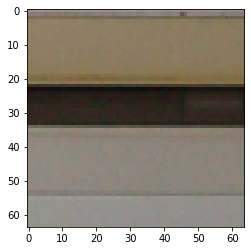

In [14]:
import matplotlib.pyplot as plt

test = x_cv[2]

plt.imshow(test)

In [15]:
import requests
from imageio import imread

def sample_test_image(img):
    kernel_size = 64
    stride = 8
    i = 0

    samples = np.ndarray(shape=(((img.shape[0] - kernel_size)//stride+1)*(
        (img.shape[1] - kernel_size)//stride+1), 64, 64, 3), dtype=np.dtype('uint8'))

    for y_start in range(0, img.shape[0] - kernel_size + 1, stride):
        for x_start in range(0, img.shape[1] - kernel_size + 1, stride):
            samples[i, :, :, :] = img[y_start:y_start +
                                      kernel_size, x_start:x_start + kernel_size, :3]
            i += 1

    return samples

list_url = [
    # 'https://i.ibb.co/4j1yxMR/152681a0017a5fded699c43cd6df97d1.png', #fake from dataset
    # 'https://i.stack.imgur.com/peB3w.png', #7 digit display
    # 'https://i.stack.imgur.com/MIe6s.png', #7 digit display
    # 'https://i.stack.imgur.com/2rbal.png', #7 digit display
    # 'https://i.stack.imgur.com/KUfwD.png', #7 digit display
    # 'https://i.stack.imgur.com/oGsK8.png',  #7 digit display
    # 'https://medialampung.co.id/wp-content/uploads/2020/01/KWH-Pascabayar.jpg', #fake
    # 'https://i.ibb.co/Hp4FCcZ/1622199455244.jpg', #pristine
    # 'https://i.ibb.co/6WXN05s/13989611014162.jpg' #pristine
    'https://i.ibb.co/gPfCLnb/31311633f92518299051f6c846919af1.png'
]

list_result = []

for image_url in list_url:
    response = requests.get(image_url)
    original_image = imread(response.content)
    image = sample_test_image(original_image)

    result = model_aug.predict(image)

    list_result.append(result)

    # print(f'Url: {image_url}, Fake (0.1): {(result > 0.1).sum()/len(result)}')
    # print(f'Url: {image_url}, Fake (0.25): {(result > 0.25).sum()/len(result)}')
    # print(f'Url: {image_url}, Fake (0.5): {(result > 0.5).sum()/len(result)}')
    # print(f'Url: {image_url}, Fake (0.75): {(result > 0.75).sum()/len(result)}')
    # print(f'Url: {image_url}, Fake (0.8): {(result > 0.8).sum()/len(result)}')
    # print(f'Url: {image_url}, Fake (0.9): {(result > 0.9).sum()/len(result)}', end="\n\n")

    print(f'Url: {image_url}, Fake (0.5): {(result > 0.5).sum()/len(result) > 0.5}')

for result in list_result:
  print(result, end="\n\n=========================================================================\n\n")

Url: https://i.ibb.co/gPfCLnb/31311633f92518299051f6c846919af1.png, Fake (0.5): False
[[9.323525e-10]
 [3.454715e-03]
 [6.890657e-11]
 ...
 [9.972671e-01]
 [9.695415e-01]
 [9.878453e-01]]


